In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

class Scen_gen():
    def __init__(self, spot, drift, vol):
        self.spot = spot
        self.drift = drift
        self.vol = vol
        
    #def LV(self, s, t):               
    
    def MC(self, sims, timesteps, dt):
        x = np.zeros((sims, timesteps + 1))
        for i in range(sims):
            for j in range(timesteps + 1):
                z1 = np.random.normal(0, 1)
                if j == 0:
                    x[i, j] = self.spot  
                else:
                    x[i, j] = x[i, j - 1] * np.exp((self.drift - 0.5 * self.vol ** 2) * dt + (self.vol * dt ** 0.5 * z1))
        return x

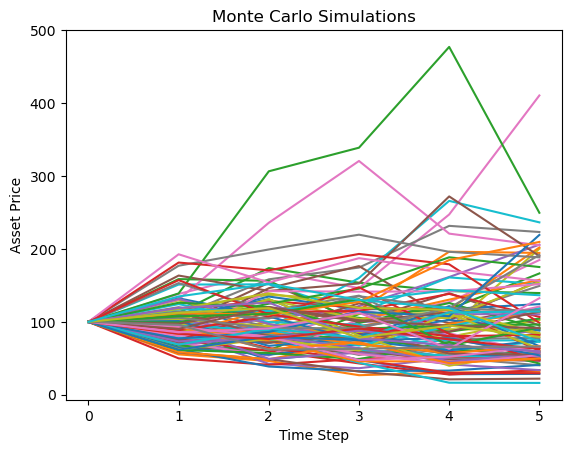

In [3]:
#plots 

spot_price = 100
strike_price = 80
time_to_maturity = 10
drift = 0
vol = 0.2

scenario_generator = Scen_gen(spot_price, drift, vol)

# Generate Monte Carlo scenarios
num_simulations = 10000
num_time_steps = 5
time_step_size = time_to_maturity / num_time_steps
scenarios = scenario_generator.MC(num_simulations, num_time_steps, time_step_size)

for i in range(100):
    plt.plot(scenarios[i])
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Monte Carlo Simulations')
plt.show()


Implied volatility grid has been written to 'implied_volatility_grid.txt'.


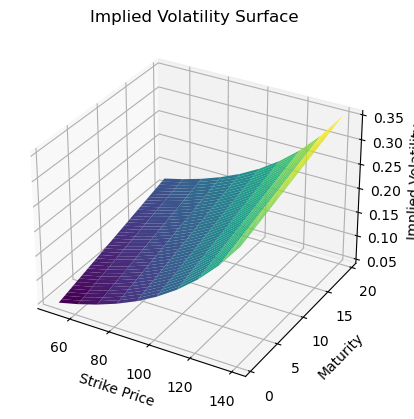

In [4]:
strikes = np.arange(50, 150, 10)
maturities = np.arange(0.5, 20, 0.5)

grid = np.zeros((len(strikes), len(maturities)))

def implied_volatility_smile(strike, maturity):
    a = 0.5  # Parameter controlling the smile shape
    b = 0.02  # Parameter controlling the smile shift
    c = 0.6  # Parameter controlling the slope of volatility with maturity
    return (a * np.exp(b * strike) + 0.2 * (c * maturity))/30

for i in range(len(strikes)):
    for j in range(len(maturities)):
        implied_volatility = implied_volatility_smile(strikes[i], maturities[j])
        grid[i,j] = implied_volatility 
        
#print(grid)

filename = "implied_volatility_grid.txt"

with open(filename, "w") as file:
    file.write("\t" + "\t".join(map(str, maturities)) + "\n")
    for i in range(len(strikes)):
        file.write(str(strikes[i]) + "\t" + "\t".join(map(str, grid[i])) + "\n")

print(f"Implied volatility grid has been written to '{filename}'.")

strike_grid, maturity_grid = np.meshgrid(strikes, maturities)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(strike_grid, maturity_grid, grid.T, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')
plt.show()

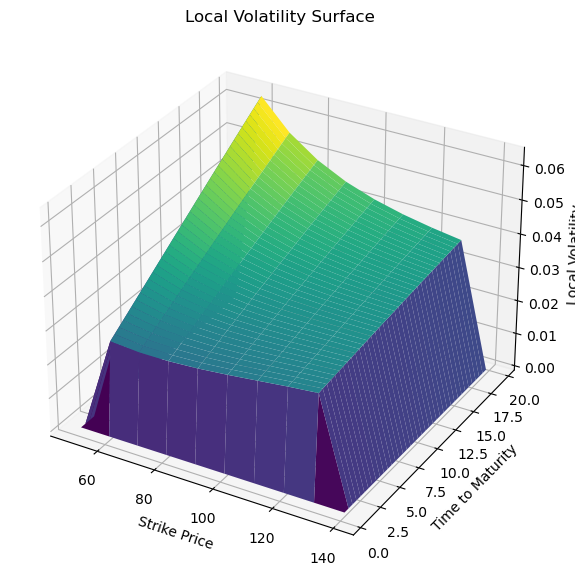

In [5]:
#dupire local vol - basic - not log strike - no interp/extrap

from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

strikes = np.arange(50, 150, 10)
maturities = np.arange(0.5, 20, 0.5)
r = 0.03

def implied_volatility_smile(strike, maturity):
    a = 0.5  # smile shape
    b = 0.02  # skew
    c = 0.6  # slope
    return (a * np.exp(b * strike) + 0.2 * (c * maturity))/30

IV = np.zeros((len(strikes), len(maturities)))

for i in range(len(strikes)):
    for j in range(len(maturities)):
        IV[i, j] = implied_volatility_smile(strikes[i], maturities[j])

local_volatility = np.zeros_like(IV)

for i in range(1, len(maturities)):
    for j in range(1, len(strikes) - 1):
        dt = maturities[i] - maturities[i - 1]
        dK = strikes[j + 1] - strikes[j - 1]

        dIV_dt = (IV[j, i] - IV[j, i - 1]) / dt
        dIV_dK = (IV[j + 1, i] - IV[j - 1, i]) / (2 * dK)
        d2IV_dK2 = (IV[j + 1, i] - 2 * IV[j, i] + IV[j - 1, i]) / (dK ** 2)

        d1 = (np.log(strikes[j]/strikes[j]) + (r + 0.5 * IV[j, i] ** 2) * maturities[i]) / (IV[j, i] * np.sqrt(maturities[i]))

        numerator = dIV_dt + r * strikes[j] * dIV_dK + r * IV[j, i]
        denominator = 0.5 * strikes[j] ** 2 * (d2IV_dK2 + d1 * dIV_dK / (IV[j, i] * np.sqrt(maturities[i])))
        
        local_volatility[j, i] = np.sqrt(numerator / denominator)

X, T = np.meshgrid(strikes, maturities)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, local_volatility.T, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Local Volatility')
ax.set_title('Local Volatility Surface')

plt.show()




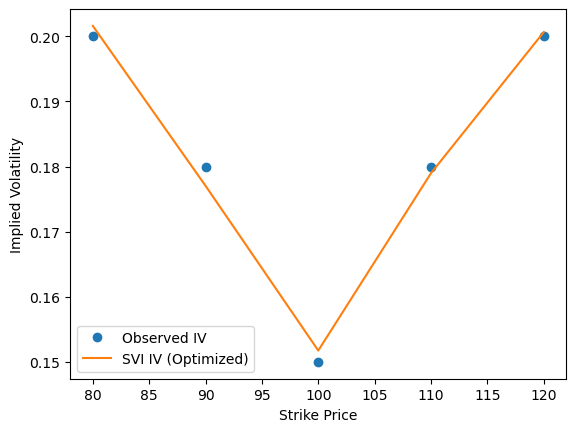

In [7]:
#gatheral SVI - paramatization of 

from scipy.optimize import minimize

strike_prices = np.array([80, 90, 100, 110, 120])
observed_iv = np.array([0.2, 0.18, 0.15, 0.18, 0.2])

F = 100

def svi_volatility(k, a, b, rho, m, sigma):
    return np.sqrt(a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2)))

def objective(params):
    a, b, rho, m, sigma = params
    model_iv = svi_volatility(np.log(strike_prices / F), a, b, rho, m, sigma)
    return np.sum((model_iv - observed_iv)**2)


initial_params = [0.04, 0.1, -0.4, 0.0, 0.1]

bounds = [(0, None), (0, None), (-1, 1), (None, None), (0, None)]

result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')

a_opt, b_opt, rho_opt, m_opt, sigma_opt = result.x

k = np.log(strike_prices / F)
optimized_iv = svi_volatility(k, a_opt, b_opt, rho_opt, m_opt, sigma_opt)

plt.plot(strike_prices, observed_iv, 'o', label='Observed IV')
plt.plot(strike_prices, optimized_iv, label='SVI IV (Optimized)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()


In [15]:
#SABR Implememtation - calculate an array of random normal variates

def simulate_sabr(alpha, beta, rho, F0, sigma0, T, n_steps):
    dt = T/n_steps
   
    dw_F = np.random.randn(n_steps)
    dw_sigma = rho * dw_F + np.sqrt(1 - rho**2) * np.random.randn(n_steps)

    F = np.zeros(n_steps)
    sigma = np.zeros(n_steps)
    F[0] = F0
    sigma[0] = sigma0

    for t in range(1, n_steps):
        F[t] = F[t-1] + sigma[t-1] * (F[t-1]**beta) * dw_F[t-1]
        sigma[t] = sigma[t-1] + alpha * sigma[t-1] * dw_sigma[t-1]
        F[t] = max(F[t], 0)  

    return F, sigma

alpha, beta, rho = 0.1, 0.9, -0.4
F0, sigma0, T, n_steps = 0.02, 0.2, 1, 10

F, sigma = simulate_sabr(alpha, beta, rho, F0, sigma0, T, n_steps)

#print(F)
#print(sigma)

def sabr_iv(F, K, T, alpha, beta, rho, nu):

    # Calculate z and xz
    z = nu/alpha * ((F * K)**((1-beta)/2)) * np.log(F/K)
    xz = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    
    # Calculate volatility A, B, C, D terms
    A = 1 + (((1-beta)**2 * alpha**2) / (24 * (F * K)**(1-beta)) + (alpha * beta * rho * nu) / (4 * (F * K)**((1-beta)/2)) + (2 - 3 * rho**2) * nu**2 / 24) * T
    B = (1 + ((1-beta)**2 / 24) * ((2 * np.log(F/K))**2) + ((1-beta)**4 / 1920) * ((2 * np.log(F/K))**4)) / ((F * K)**((1-beta)/2))
    C = (1 + ((1-beta)**2 / 24) * np.log(F/K)**2 + ((1-beta)**4 / 1920) * np.log(F/K)**4)
    D = alpha / ((F * K)**((1-beta)/2) * C) * z/xz
    
    # Return volatility
    return A * D * B

def objective_function(params, F, K, T, market_vols):
    alpha, rho, nu = params
    beta = 0.9
    model_vols = sabr_iv(F, K, T, alpha, beta, rho, nu)
    error = np.sum((market_vols - model_vols)**2)
    return error

def calibrate_sabr(F, K, T, market_vols):
    # Initial guesses
    alpha_guess = 0.2
    rho_guess = 0.0
    nu_guess = 0.2
    
    result = minimize(objective_function, [alpha_guess, rho_guess, nu_guess], args=(F, K, T, market_vols), 
                      bounds=[(0.001, 5), (-0.999, 0.999), (0.001, 5)])
    
    return result.x

# Example usage
F = np.array([0.02, 0.03, 0.04])  # Forward rates
K = np.array([0.01, 0.03, 0.05])  # Strike rates
T = np.array([1, 2, 3])           # Maturities
market_vols = np.array([0.2, 0.25, 0.3])  # Observed implied volatilities

alpha, rho, nu = calibrate_sabr(F, K, T, market_vols)
print(alpha, rho, nu)



[-1.51627515  1.44818299 -0.22640542  0.33712806  0.29058025  2.04974438
  0.18666831 -0.19147823 -0.1860183  -0.58427027]
0.2 0.0 0.2


C:\Users\Laptop\AppData\Local\Temp\ipykernel_8184\1770668556.py:40: RuntimeWarning: invalid value encountered in divide
  D = alpha / ((F * K)**((1-beta)/2) * C) * z/xz


In [8]:
#Instruments 

#European from MC

class EuroOptionPricer():
    def __init__(self, spot, strike, maturity, drift):
        self.spot = spot
        self.strike = strike
        self.maturity = maturity
        self.drift = drift
    
    def european_call_price(self, scenarios):
        # Calculate the payoff for each scenario at maturity
        call_payoffs = np.maximum(scenarios[:, -1] - self.strike, 0)
        
        # Calculate the option price as the expected value of the payoffs
        option_price = np.mean(call_payoffs) * np.exp(-self.maturity * self.drift)
        
        return option_price

    def european_put_price(self, scenarios):
        # Calculate the payoff for each scenario at maturity
        put_payoffs = np.maximum(self.strike - scenarios[:, -1], 0)
        
        # Calculate the option price as the expected value of the payoffs
        option_price = np.mean(put_payoffs) * np.exp(-self.maturity * self.drift)
        
        return option_price

spot_price = 100
strike_price = 80
time_to_maturity = 10
drift = 0
vol = 0.2

scenario_generator = Scen_gen(spot_price, drift, vol)

# Generate Monte Carlo scenarios
num_simulations = 10000
num_time_steps = 5
time_step_size = time_to_maturity / num_time_steps
scenarios = scenario_generator.MC(num_simulations, num_time_steps, time_step_size)
#print(scenarios)

option_pricer = EuroOptionPricer(spot_price, strike_price, time_to_maturity, drift)

call_option_price = option_pricer.european_call_price(scenarios)
put_option_price = option_pricer.european_put_price(scenarios)

print(f"Theoretical European Call Option Price: {call_option_price:.2f}")
print(f"Theoretical European Put Option Price: {put_option_price:.2f}")

def black_scholes(S, K, T, r, sigma, option_type='call'):

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        option_price = S * N_d1 - K * np.exp(-r * T) * N_d2
    elif option_type == 'put':
        N_d1 = norm.cdf(-d1)
        N_d2 = norm.cdf(-d2)
        option_price = K * np.exp(-r * T) * N_d2 - S * N_d1
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price


S = spot_price
K = strike_price
T = time_to_maturity
r = drift
sigma = vol

call_option_price = black_scholes(S, K, T, r, sigma, option_type='call')
put_option_price = black_scholes(S, K, T, r, sigma, option_type='put')

print(f"Theoretical Call Option Price: {call_option_price:.2f}")
print(f"Theoretical Put Option Price: {put_option_price:.2f}")


Theoretical European Call Option Price: 33.12
Theoretical European Put Option Price: 13.73
Theoretical Call Option Price: 33.66
Theoretical Put Option Price: 13.66
